In [61]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join

       

In [49]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

Number of train samples: 60000
Number of test samples: 10000


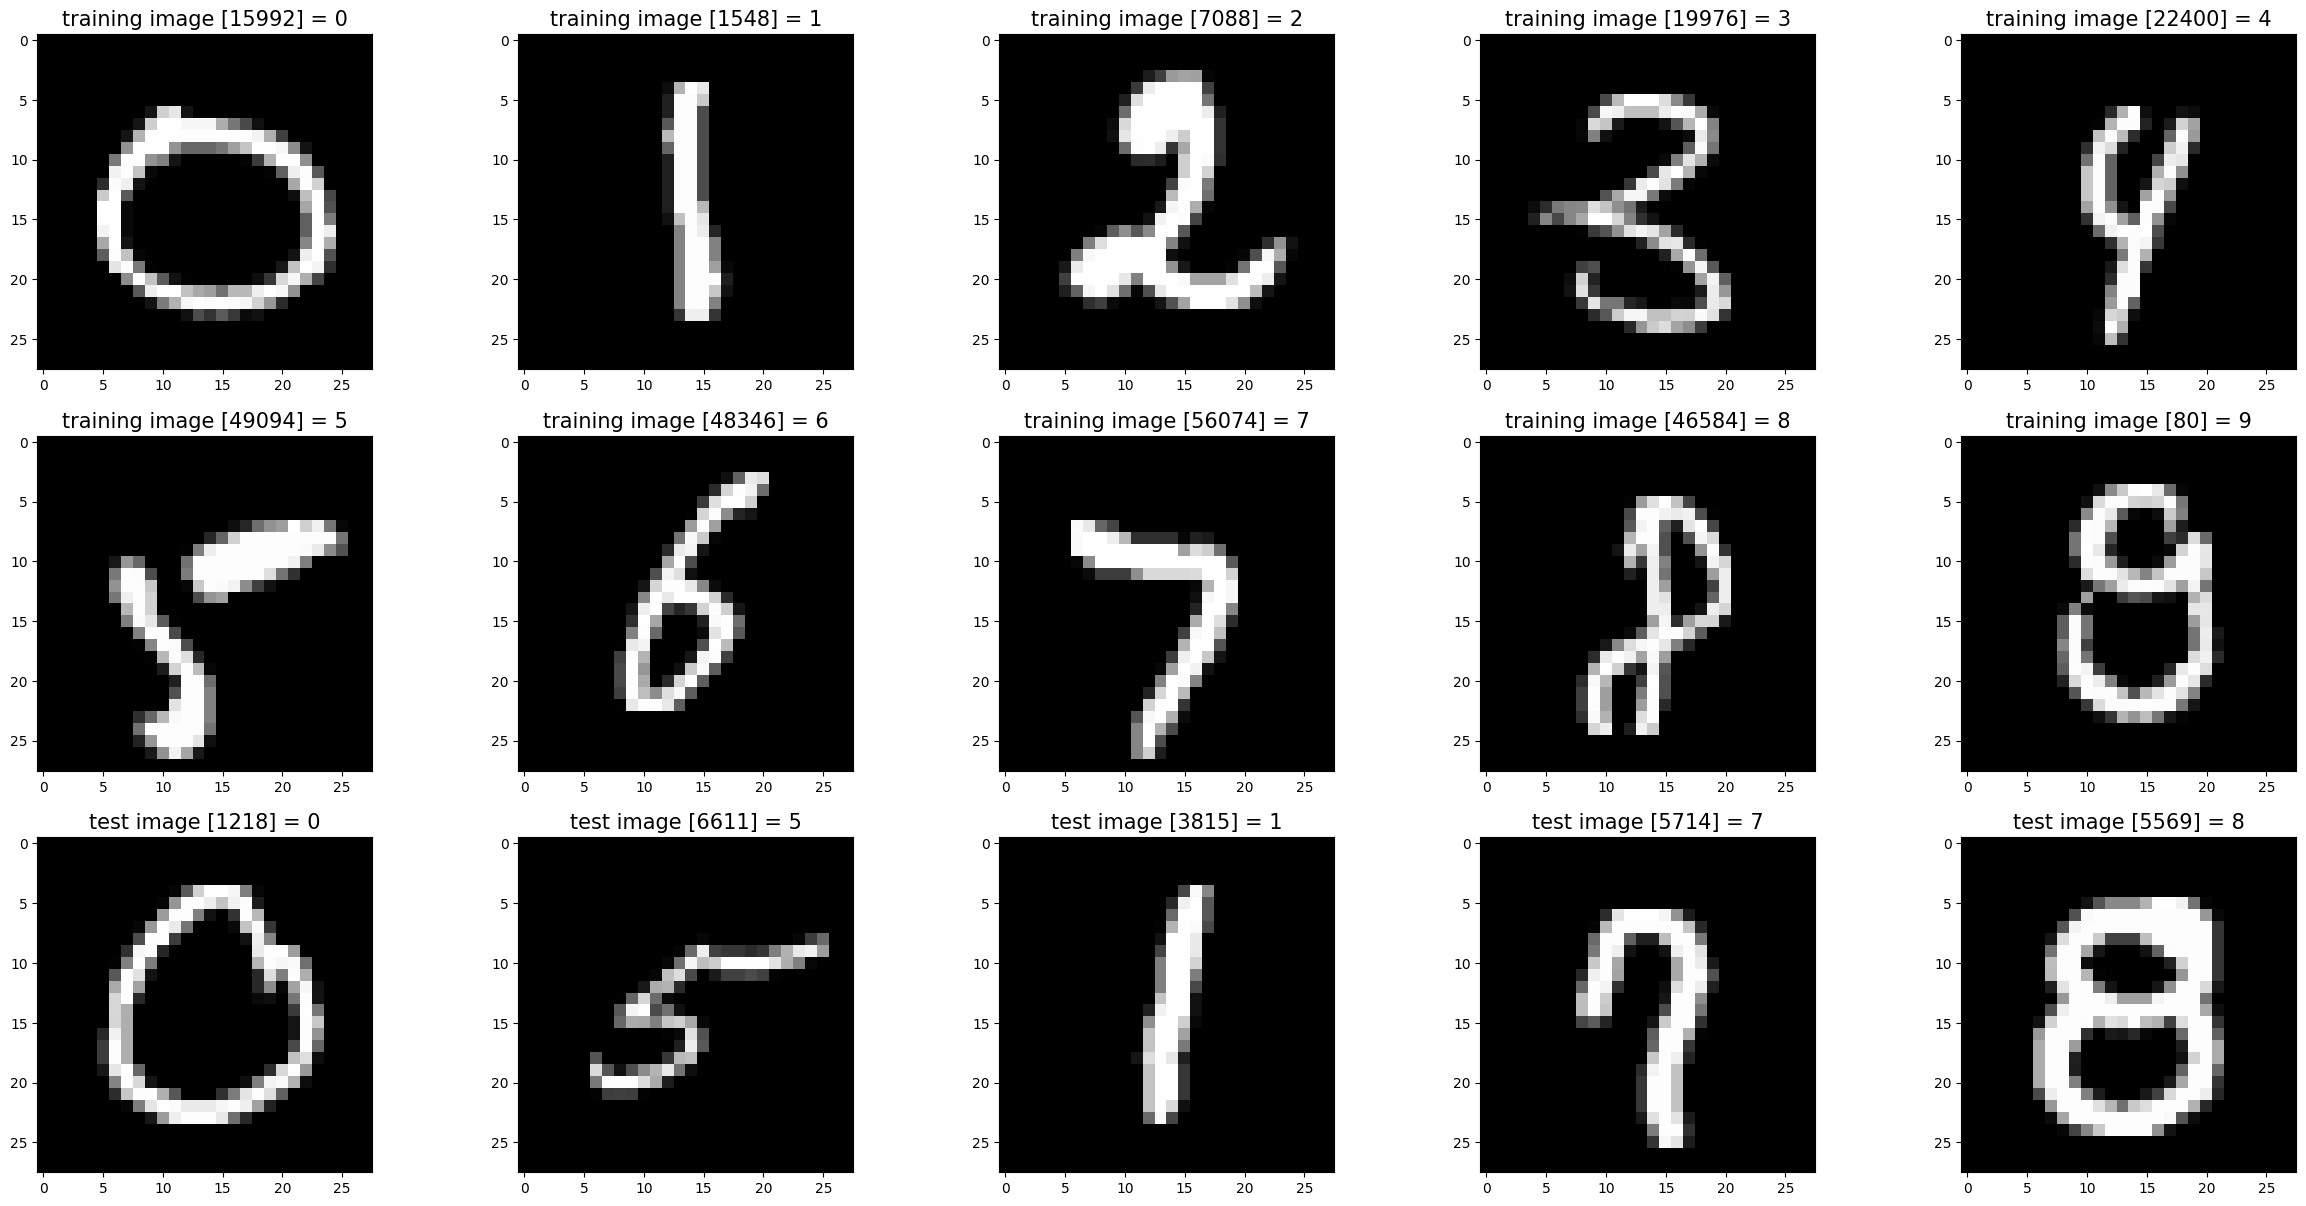

In [50]:
#
# Проверка чтения mnist
#
%matplotlib inline
import random

input_path = 'C:\\Users\\Andrew\\Desktop\\DeepLearning\\mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte\\train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte\\train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte\\t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte\\t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('Number of train samples: {}'.format(len(x_train)))
print('Number of test samples: {}'.format(len(x_test)))
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
r=0
for i in range(0, 10):
    while(y_train[r] != i): #show all 10 digits
        r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [51]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [52]:
def relu(x):
    return np.maximum(0, x)

# derivative of ReLU for back propagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

In [53]:
# loss function
def cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = - np.log(y_pred[range(n_samples), y_true])
    return np.sum(logp) / n_samples

# derivative of the loss function for back propagation
def delta_cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred
    grad[range(n_samples), y_true] -= 1
    return grad / n_samples


In [54]:
def initialize_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size) #Hidden layer weigts
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size) #Output layer weigts
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

In [55]:
# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = X.dot(W1) + b1 
    A1 = relu(Z1) #Calculating the outputs of neurons on the hidden layer
    Z2 = A1.dot(W2) + b2
    A2 = softmax(Z2)  #Calculating the outputs of network
    return Z1, A1, Z2, A2

In [56]:
# Back propagation
def backward_propagation(X, y, Z1, A1,b1,b2, A2, W1, W2, learning_rate):
    m = X.shape[0] #batch size
    dA2 = delta_cross_entropy(y, A2)
    dW2 = A1.T.dot(dA2)
    db2 = np.sum(dA2, axis=0, keepdims=True)

    dA1 = dA2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T.dot(dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    W1 -= learning_rate * dW1 / m
    b1 -= learning_rate * db1 / m
    W2 -= learning_rate * dW2 / m 
    b2 -= learning_rate * db2 / m

    return W1, b1, W2, b2

In [57]:
def train(x_train, y_train, x_test, y_test, hidden_size, learning_rate, batch_size, epochs, flag):
    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        # Mixing data
        indices = np.random.permutation(x_train.shape[0])
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            X_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            W1, b1, W2, b2 = backward_propagation(X_batch, y_batch, Z1, A1,b1,b2, A2, W1, W2, learning_rate)

        # Evaluation on training and test samples
        _, _, _, train_predictions = forward_propagation(x_train, W1, b1, W2, b2)
        train_loss = cross_entropy(y_train, train_predictions)
        train_acc = np.mean(np.argmax(train_predictions, axis=1) == y_train)
        
        _, _, _, test_predictions = forward_propagation(x_test, W1, b1, W2, b2)
        test_loss = cross_entropy(y_test, test_predictions)
        test_acc = np.mean(np.argmax(test_predictions, axis=1) == y_test)
        if flag == 1:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        

            print(f'Train Accuracy: {train_acc:.4f}% , Test Accuracy: {test_acc:.4f}')
    return test_acc

Параметры для обучения:

In [59]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
epochs = 20
batch_size = 20
learning_rate = 0.1
# Normalize data
X_train = x_train.reshape(-1, 28*28) / 255.0
X_test = x_test.reshape(-1, 28*28) / 255.0

train(X_train, y_train, X_test, y_test, hidden_size,learning_rate, batch_size,  epochs, 1)


Epoch 1/20, Train Loss: 0.4227, Test Loss: 0.4029
Train Accuracy: 0.8888% , Test Accuracy: 0.8951
Epoch 2/20, Train Loss: 0.3347, Test Loss: 0.3202
Train Accuracy: 0.9062% , Test Accuracy: 0.9112
Epoch 3/20, Train Loss: 0.2959, Test Loss: 0.2846
Train Accuracy: 0.9172% , Test Accuracy: 0.9213
Epoch 4/20, Train Loss: 0.2710, Test Loss: 0.2612
Train Accuracy: 0.9240% , Test Accuracy: 0.9268
Epoch 5/20, Train Loss: 0.2507, Test Loss: 0.2449
Train Accuracy: 0.9305% , Test Accuracy: 0.9313
Epoch 6/20, Train Loss: 0.2335, Test Loss: 0.2293
Train Accuracy: 0.9348% , Test Accuracy: 0.9348
Epoch 7/20, Train Loss: 0.2192, Test Loss: 0.2161
Train Accuracy: 0.9381% , Test Accuracy: 0.9387
Epoch 8/20, Train Loss: 0.2063, Test Loss: 0.2054
Train Accuracy: 0.9428% , Test Accuracy: 0.9426
Epoch 9/20, Train Loss: 0.1943, Test Loss: 0.1950
Train Accuracy: 0.9456% , Test Accuracy: 0.9450
Epoch 10/20, Train Loss: 0.1855, Test Loss: 0.1866
Train Accuracy: 0.9480% , Test Accuracy: 0.9471
Epoch 11/20, Train 

0.9627

График зависимости качества обучения от размера пачки:

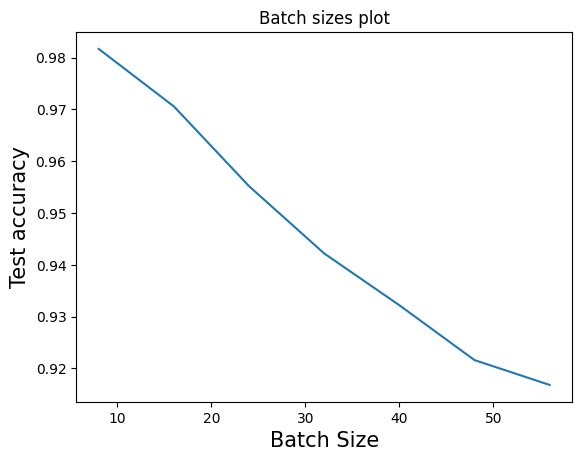

In [65]:

sizes = []
Accs =[]
for batch_size in range(8, 64, 8):
    sizes.append(batch_size)
    Accs.append(train(X_train, y_train, X_test, y_test, hidden_size,learning_rate, batch_size,  epochs, 0))


plt.title('Batch sizes plot')
ax = plt.gca()
ax.set_xlabel("Batch Size", fontsize=15)
ax.set_ylabel("Test accuracy", fontsize=15)

plt.plot(sizes, Accs)
plt.show()